In [1]:
%matplotlib inline

import math
import pytz 
import traceback
import time
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import cPickle as pickle

In [2]:
%run src/data/helper.py

In [3]:
start_time = time.time()

with open('data/parsed/stations_clean.p', 'rb') as f:
    stations = pickle.load(f)

with open('data/parsed/readings_clean.p', "rb") as f:
    readings = pickle.load(f)

end_time = time.time()
print 'Opening redistribution data took %s' % (end_time - start_time)

Opening redistribution data took 261.504618883


## Fill Distribution

## Column Analysis

In [4]:
columns = ['CollNbBikes', 'DewPt', 'DistNbBikes', 'Humidity', 'NbBikes', 'Rain', 'Temp', 'Visibility',
           'WindSpeed', 'TimeOfDay']

data = readings.sample(frac=0.005)[columns]

### Pair Plot

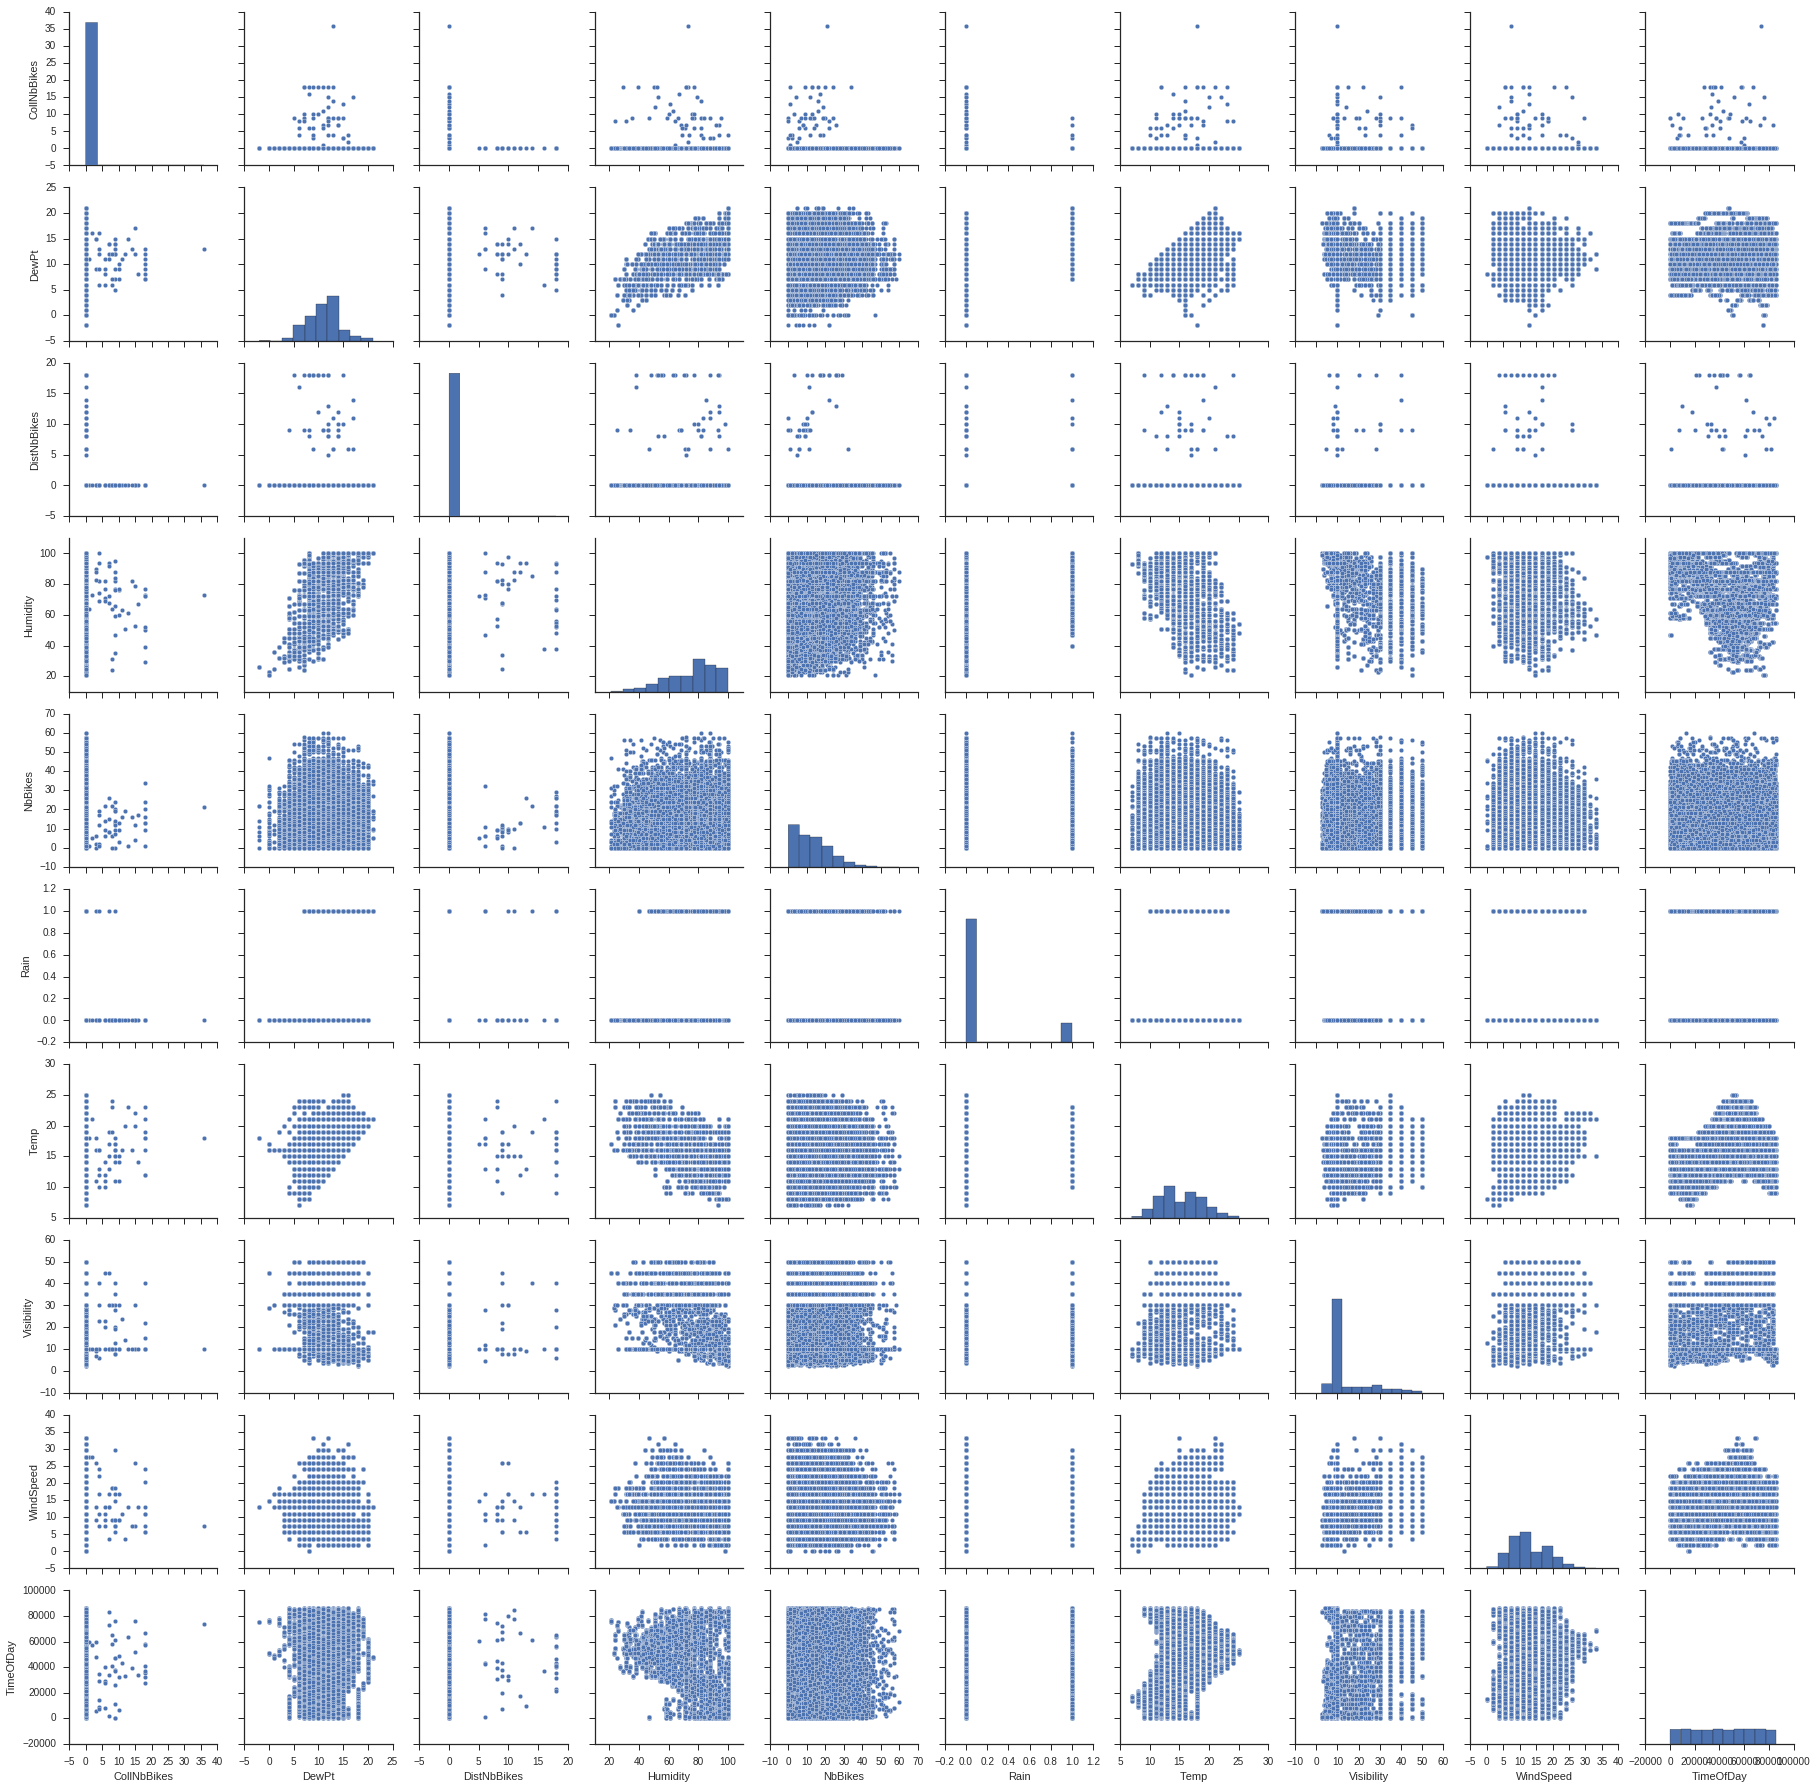

In [5]:
sns.set(style="ticks", color_codes=True)

# takes too long!
g = sns.pairplot(data)
g.savefig('destination_path.eps', format='eps', dpi=1000)
g

### Correlation Analysis

In [3]:
corr = data.corr()

NameError: name 'data' is not defined

In [4]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_yticklabels(g.get_yticklabels(), rotation=0)

NameError: name 'corr' is not defined

## Split Dataset

In [4]:
split_training = lambda df: df[datetime(2016,5,15,0,0,0,0):datetime(2016,6,12,23,59,59,999999)]
split_validation = lambda df: df[datetime(2016,6,13,0,0,0,0):datetime(2016,6,19,23,59,59,999999)]
split_test = lambda df: df[datetime(2016,5,20,0,0,0,0):datetime(2016,6,26,23,59,59,999999)]

In [5]:
def split_datasets(df, station_id):
    station_df = df.loc[station_id]
    training = split_training(station_df)
    validation = split_validation(station_df)
    test = split_test(station_df)
    
    return training, validation, test

## Model Definitions

In [6]:
import sys

def clip_and_round(arr):
    arr = np.clip(arr, 0, sys.maxint)
    return np.round(arr)

In [7]:
last_data = None

In [8]:
import inspect

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error

from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector, Formula

pandas2ri.activate()

r = robjects.r
base = importr('base')
stats = importr('stats')
mgcv = importr('mgcv')

class GAMRegressor(BaseEstimator, RegressorMixin):      
    last_data = None

    def __init__(self, features=None, formula_str=None,
                 FogTMinus2_parametric=None, RainTMinus2_parametric=None,
                 DistNbBikes_parametric=None, CollNbBikes_parametric=None, 
                 TempTMinus2AndHumidityTMinus2_sp=None,
                 NbBikesTMinus2_sp=None, NbBikesTMinus3_sp=None, 
                 NbBikesTMinus12_sp=None, NbBikesTMinus18_sp=None,             
                 TimeOfDay_1_sp=None, TimeOfDay_2_sp=None, TimeOfDay_3_sp=None,
                 TimeOfDay_1_by=None, TimeOfDay_2_by=None, TimeOfDay_3_by=None):
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")

        self.args_to_set = []
        for arg, val in values.items():
            # save a list of the arguments
            if arg != 'features' and arg != 'formula_str':
                self.args_to_set.append(arg)
            setattr(self, arg, val)

    def fit(self, X, y=None): 
        if self.formula_str is None:
            features_dicts = self.build_features_dicts()
            self.formula_str = self.build_formula_str(features_dicts)       
            
        GAMRegressor.last_data=X
            
        frm = Formula(self.formula_str)
        self.gam = mgcv.gam(frm, data=X)
        
        return self

    def predict(self, X):
        assert (self.gam is not None), "GAM must be set"
        p_val = clip_and_round(stats.predict(self.gam, newdata=X))
        return p_val
    
    def score(self, X):
        p_val = self.predict(X)
        y_val = X.NbBikes
        rmse = mean_squared_error(y_val, p_val)**0.5
        return rmse * (-1)
    
    def build_features_dicts(self):
        assert (self.features is not None), "features must be set"
        
        # initialize the dictionaries
        features_dicts = {}
        for feature in self.features:
            features_dicts[feature] = {
                'name': feature,
                'bs': 'tp',
                'sp': None,
                'by': None,
                'k': None,
                'parametric': False
            }
            
        # set parameter values
        for arg in self.args_to_set:
            val = getattr(self, arg)
            if val is None:
                continue
            feature, parameter = arg.rsplit('_',1)
            features_dicts[feature][parameter] = val
            
        return features_dicts
    
    def build_formula_str(self, features_dicts):
        formula = 'NbBikes ~ '
        for feature, feature_dict in features_dicts.iteritems():
            if feature_dict['parametric']:
                formula += '%(name)s+' % feature_dict
                continue
                                
            tokens = feature_dict['name'].split('_')
            name, index = (tokens[0],None) if len(tokens) == 1 else (tokens[0], tokens[1])
            formula += "s(%s" % name.replace('And', ',')
            
            if feature_dict['bs'] is not None:
                formula += ", bs='%s'" % feature_dict['bs']
            if feature_dict['sp'] is not None:
                formula += ", sp=%f" % feature_dict['sp']
            if feature_dict['by'] is not None:
                formula += ", by=%s" % feature_dict['by']
            if feature_dict['k'] is not None:
                formula += ", k=%s" % feature_dict['k']
                
            formula += ")+" % feature_dict
        return formula[:-1]
    
class LRegressor(BaseEstimator, RegressorMixin):  
    def __init__(self, formula_str):
    	self.formula_str = formula_str

    def fit(self, X, y=None):            
        self.lr = stats.lm(Formula(self.formula_str), data=X)        
        return self

    def predict(self, X):
        assert (self.lr is not None), "LR must be set"
        p_val = clip_and_round(stats.predict(self.lr, newdata=X))
        return p_val
    
    def score(self, X):
        p_val = self.predict(X)
        y_val = X.NbBikes
        rmse = mean_squared_error(y_val, p_val)**0.5
        return rmse * (-1)   

In [9]:
from sklearn.linear_model import LinearRegression

def fit_and_predict_lm(training, validation, formula):
    lm = LRegressor(formula_str=formula)
    lm.fit(training)
    return lm, clip_and_round(lm.predict(validation))

In [10]:
def fit_and_predict_gam(training, validation, formula):
    gam = GAMRegressor(formula_str=formula)
    gam.fit(training)
    return gam, clip_and_round(gam.predict(validation))

In [11]:
def model(df, station_ids, gam_formula, lr_formula, pred_col):
    results = []

    for station_id in station_ids:
        print 'Fitting %s' % station_id
            
        training, validation, test = split_datasets(df, station_id)      
        y_val = validation[pred_col]
        
        try:            
            # Linear Model
            lm_fit = fit_and_predict_lm(training, validation, lr_formula)
            lm_rmse = mean_squared_error(y_val, lm_fit[1])**0.5
        
            # GAM Model
            gam_fit = fit_and_predict_gam(training, validation, gam_formula)
            gam_rmse = mean_squared_error(y_val, gam_fit[1])**0.5
        except Exception as e:
            logging.error(traceback.format_exc())
        
        results.append({'Id': station_id, 'LR-ERR': lm_rmse, 'GAM-ERR': gam_rmse})
        
    return results

In [12]:
def convert_results_to_df(results, name):
    dfs = [pd.DataFrame(result).set_index('Id') for result in results]
    for i,df in enumerate(dfs):
        df.columns = ['%s-EXP%d-%s' % (name, i,col) for col in df.columns]
    return pd.concat(dfs, axis=1)

## Use Samples?

In [13]:
use_samples = True

if use_samples:
    with open("data/parsed/stations_sample.p", "rb") as f:
        stations_to_use = pickle.load(f)
else:
    stations_to_use = readings.index.get_level_values(0).unique().tolist()

In [ ]:
print 'Saved stations'

# Short Term Predictions

In [85]:
gam_formula_short = "NbBikes ~ s(TempTMinus2, HumidityTMinus2, bs='tp') + s(TimeOfDay, by=Weekday, bs='tp') "  
gam_formula_short += "+ s(TimeOfDay, by=Weekend, bs='tp') + s(TimeOfDay, by=Holiday, bs='tp') + s(NbBikesTMinus2, bs='tp') "
gam_formula_short += "+ s(NbBikesTMinus3, bs='tp') + RainTMinus2 + FogTMinus2 "

In [86]:
lr_formula_short = "NbBikes ~ TempTMinus2 + HumidityTMinus2 + TimeOfDay + Weekday "
lr_formula_short += "+ NbBikesTMinus2 + NbBikesTMinus3 + RainTMinus2 + FogTMinus2 "

## Baseline

In [87]:
# choose the columns to use in the model
boolean_cols_short = ['Weekday', 'Weekend', 'Holiday', 'RainTMinus2', 'FogTMinus2']
numeric_cols_short = ['HumidityTMinus2', 'TempTMinus2', 'TimeOfDay',
                      'NbBikesTMinus2', 'NbBikesTMinus3']                       
pred_col_short = 'NbBikes'

feature_cols_short = numeric_cols_short + boolean_cols_short
cols_short = [pred_col_short] + feature_cols_short

# select the columns chosen columns
readings_short = readings.loc[stations_to_use][cols_short]

# remove na
readings_short.dropna(inplace=True)

In [88]:
baseline_short = [model(readings_short, stations_to_use, gam_formula_short, lr_formula_short, 'NbBikes')]

Fitting BikePoints_649
Fitting BikePoints_20
Fitting BikePoints_34
Fitting BikePoints_305
Fitting BikePoints_621
Fitting BikePoints_85
Fitting BikePoints_624
Fitting BikePoints_478
Fitting BikePoints_325
Fitting BikePoints_484
Fitting BikePoints_190
Fitting BikePoints_291
Fitting BikePoints_208
Fitting BikePoints_561
Fitting BikePoints_729
Fitting BikePoints_315
Fitting BikePoints_18
Fitting BikePoints_731
Fitting BikePoints_277
Fitting BikePoints_517
Fitting BikePoints_32
Fitting BikePoints_40
Fitting BikePoints_53
Fitting BikePoints_579
Fitting BikePoints_335
Fitting BikePoints_244
Fitting BikePoints_412
Fitting BikePoints_19
Fitting BikePoints_475
Fitting BikePoints_481
Fitting BikePoints_56
Fitting BikePoints_299
Fitting BikePoints_352
Fitting BikePoints_300
Fitting BikePoints_818
Fitting BikePoints_627
Fitting BikePoints_717
Fitting BikePoints_505
Fitting BikePoints_398
Fitting BikePoints_286
Fitting BikePoints_770
Fitting BikePoints_59
Fitting BikePoints_248
Fitting BikePoints_37

In [89]:
baseline_short_df = convert_results_to_df(baseline_short, 'BASE')
baseline_short_df[['BASE-EXP0-GAM-ERR', 'BASE-EXP0-LR-ERR']].mean()

BASE-EXP0-GAM-ERR    1.040339
BASE-EXP0-LR-ERR     1.055237
dtype: float64

In [90]:
with open("data/parsed/baseline_short.p", "wb") as f:
    pickle.dump(baseline_short, f)

## Redistribution Experiments

In [91]:
bicycle_redistribution_experiments = [('CollNbBikes', 'DistNbBikes'), ('CollNbBikesCum2', 'DistNbBikesCum2'), ('CollNbBikesCum6', 'DistNbBikesCum6')]

In [92]:
# choose the columns to use in the model
redistribution_cols = ['CollNbBikes' , 'CollNbBikesCum2', 'CollNbBikesCum6', 'DistNbBikes' , 'DistNbBikesCum2', 'DistNbBikesCum6']
boolean_cols_short = ['Weekday', 'Weekend', 'Holiday', 'RainTMinus2', 'FogTMinus2']
numeric_cols_short = ['HumidityTMinus2', 'TempTMinus2', 'TimeOfDay',
                      'NbBikesTMinus2', 'NbBikesTMinus3']                       
pred_col_short = 'NbBikes'

feature_cols_short = numeric_cols_short + boolean_cols_short + redistribution_cols
cols_short = [pred_col_short] + feature_cols_short

# select the columns chosen columns
readings_short = readings.loc[stations_to_use][cols_short]

# remove na
readings_short.dropna(inplace=True)

In [93]:
redistribution_experiments_short = []
for redistribution_columns in bicycle_redistribution_experiments:
    # add redistribution features to formula
    gam_formula = gam_formula_short
    lr_formula = lr_formula_short
        
    gam_formula += "+ %s + %s " % (redistribution_columns[0],redistribution_columns[1])
    lr_formula += "+ %s + %s " % (redistribution_columns[0],redistribution_columns[1])
    
    print '*******************************************************************'
    print 'Experiment with column %s and %s' % (redistribution_columns[0],redistribution_columns[1])
    print 'GAM Formula: %s' % gam_formula
    print 'LR Formula %s' % lr_formula
    
    results = model(readings_short, stations_to_use, gam_formula, lr_formula, 'NbBikes')    
    redistribution_experiments_short.append(results)

*******************************************************************
Experiment with column CollNbBikes and DistNbBikes
GAM Formula: NbBikes ~ s(TempTMinus2, HumidityTMinus2, bs='tp') + s(TimeOfDay, by=Weekday, bs='tp') + s(TimeOfDay, by=Weekend, bs='tp') + s(TimeOfDay, by=Holiday, bs='tp') + s(NbBikesTMinus2, bs='tp') + s(NbBikesTMinus3, bs='tp') + RainTMinus2 + FogTMinus2 + CollNbBikes + DistNbBikes 
LR Formula NbBikes ~ TempTMinus2 + HumidityTMinus2 + TimeOfDay + Weekday + NbBikesTMinus2 + NbBikesTMinus3 + RainTMinus2 + FogTMinus2 + CollNbBikes + DistNbBikes 
Fitting BikePoints_649
Fitting BikePoints_20
Fitting BikePoints_34
Fitting BikePoints_305
Fitting BikePoints_621
Fitting BikePoints_85
Fitting BikePoints_624
Fitting BikePoints_478
Fitting BikePoints_325
Fitting BikePoints_484
Fitting BikePoints_190
Fitting BikePoints_291
Fitting BikePoints_208
Fitting BikePoints_561
Fitting BikePoints_729
Fitting BikePoints_315
Fitting BikePoints_18
Fitting BikePoints_731
Fitting BikePoints_277

In [94]:
with open("data/parsed/redistribution_short.p", "wb") as f:
    pickle.dump(redistribution_experiments_short, f)

## Surrounding Stations Experiments

In [95]:
surrounding_stations_experiments = [1,2,5,10]

### Columns

In [96]:
# choose the columns to use in the model
surrounding_stations_cols = ['Near1TMinus2', 'Near1TMinus3',
                      'Near2TMinus2', 'Near2TMinus3',
                      'Near3TMinus2', 'Near3TMinus3',
                      'Near4TMinus2', 'Near4TMinus3',
                      'Near5TMinus2', 'Near5TMinus3',
                      'Near6TMinus2', 'Near6TMinus3',
                      'Near7TMinus2', 'Near7TMinus3',
                      'Near8TMinus2', 'Near8TMinus3',
                      'Near9TMinus2', 'Near9TMinus3',
                      'Near10TMinus2', 'Near10TMinus3']

boolean_cols_short = ['Weekday', 'Weekend', 'Holiday', 'RainTMinus2', 'FogTMinus2']
numeric_cols_short = ['HumidityTMinus2', 'TempTMinus2', 'TimeOfDay', 
                      'NbBikesTMinus2', 'NbBikesTMinus3']                       
pred_col_short = 'NbBikes'

feature_cols_short = numeric_cols_short + boolean_cols_short + surrounding_stations_cols
cols_short = [pred_col_short] + feature_cols_short

# select the columns chosen columns
readings_short = readings.loc[stations_to_use][cols_short]

# remove na
readings_short.dropna(inplace=True)

### Formula

In [97]:
surrounding_stations_experiments_short = []
for nb_surrounding_stations in surrounding_stations_experiments:
    surrounding_stations_features = []    

    # Generalized Additive Model
    gam_formula = gam_formula_short
    lr_formula = lr_formula_short
    if nb_surrounding_stations > 0:
        surrounding_stations_features.extend(['Near%dTMinus2' % near for near in range(1,21)][0:nb_surrounding_stations])
        surrounding_stations_features.extend(['Near%dTMinus3' % near for near in range(1,21)][0:nb_surrounding_stations])
        
        for feature in surrounding_stations_features:
            gam_formula += "+ s(%s, bs='tp') " % feature
            lr_formula += "+ %s " % feature
    
    print '*******************************************************************'
    print 'Experiment with %d surrounding stations' % nb_surrounding_stations
    print 'GAM Formula: %s' % gam_formula
    print 'LR Formula %s' % lr_formula
    
    results = model(readings_short, stations_to_use, gam_formula, lr_formula, 'NbBikes')    
    surrounding_stations_experiments_short.append(results)

*******************************************************************
Experiment with 1 surrounding stations
GAM Formula: NbBikes ~ s(TempTMinus2, HumidityTMinus2, bs='tp') + s(TimeOfDay, by=Weekday, bs='tp') + s(TimeOfDay, by=Weekend, bs='tp') + s(TimeOfDay, by=Holiday, bs='tp') + s(NbBikesTMinus2, bs='tp') + s(NbBikesTMinus3, bs='tp') + RainTMinus2 + FogTMinus2 + s(Near1TMinus2, bs='tp') + s(Near1TMinus3, bs='tp') 
LR Formula NbBikes ~ TempTMinus2 + HumidityTMinus2 + TimeOfDay + Weekday + NbBikesTMinus2 + NbBikesTMinus3 + RainTMinus2 + FogTMinus2 + Near1TMinus2 + Near1TMinus3 
Fitting BikePoints_649
Fitting BikePoints_20
Fitting BikePoints_34
Fitting BikePoints_305
Fitting BikePoints_621
Fitting BikePoints_85
Fitting BikePoints_624
Fitting BikePoints_478
Fitting BikePoints_325
Fitting BikePoints_484
Fitting BikePoints_190
Fitting BikePoints_291
Fitting BikePoints_208
Fitting BikePoints_561
Fitting BikePoints_729
Fitting BikePoints_315
Fitting BikePoints_18
Fitting BikePoints_731
Fittin

In [98]:
with open("data/parsed/surrounding_short.p", "wb") as f: 
    pickle.dump(surrounding_stations_experiments_short, f)

## All

In [99]:
# choose the columns to use in the model
surrounding_stations_cols = ['Near1TMinus2', 'Near1TMinus3', 'Near2TMinus2', 'Near2TMinus3']
redistribution_cols = ['CollNbBikes', 'DistNbBikes']
boolean_cols_short = ['Weekday', 'Weekend', 'Holiday', 'RainTMinus2', 'FogTMinus2']
numeric_cols_short = ['HumidityTMinus2', 'TempTMinus2', 'TimeOfDay', 
                      'NbBikesTMinus2', 'NbBikesTMinus3']                       
pred_col_short = 'NbBikes'

feature_cols_short = numeric_cols_short + boolean_cols_short + surrounding_stations_cols + redistribution_cols
cols_short = [pred_col_short] + feature_cols_short

# select the columns chosen columns
readings_short = readings.loc[stations_to_use][cols_short]

# remove na
readings_short.dropna(inplace=True)

In [100]:
gam_formula = gam_formula_short + "+ s(%s, bs='tp') + s(%s, bs='tp') + %s + %s " % ('Near1TMinus2','Near1TMinus3', 'CollNbBikes', 'DistNbBikes')
lr_formula = lr_formula_short + "+ %s + %s + %s + %s " % ('Near1TMinus2', 'Near1TMinus3', 'CollNbBikes', 'DistNbBikes')

In [101]:
all_short = [model(readings_short, stations_to_use, gam_formula, lr_formula, 'NbBikes')]

Fitting BikePoints_649
Fitting BikePoints_20
Fitting BikePoints_34
Fitting BikePoints_305
Fitting BikePoints_621
Fitting BikePoints_85
Fitting BikePoints_624
Fitting BikePoints_478
Fitting BikePoints_325
Fitting BikePoints_484
Fitting BikePoints_190
Fitting BikePoints_291
Fitting BikePoints_208
Fitting BikePoints_561
Fitting BikePoints_729
Fitting BikePoints_315
Fitting BikePoints_18
Fitting BikePoints_731
Fitting BikePoints_277
Fitting BikePoints_517
Fitting BikePoints_32
Fitting BikePoints_40
Fitting BikePoints_53
Fitting BikePoints_579
Fitting BikePoints_335
Fitting BikePoints_244
Fitting BikePoints_412
Fitting BikePoints_19
Fitting BikePoints_475
Fitting BikePoints_481
Fitting BikePoints_56
Fitting BikePoints_299
Fitting BikePoints_352
Fitting BikePoints_300
Fitting BikePoints_818
Fitting BikePoints_627
Fitting BikePoints_717
Fitting BikePoints_505
Fitting BikePoints_398
Fitting BikePoints_286
Fitting BikePoints_770
Fitting BikePoints_59
Fitting BikePoints_248
Fitting BikePoints_37

In [102]:
with open("data/parsed/all_short.p", "wb") as f: 
    pickle.dump(all_short, f)

## Mid Term Predictions

In [103]:
with open("data/parsed/stations_sample.p", "rb") as f:
    stations_to_use = pickle.load(f)

In [118]:
lr_formula_mid = "NbBikes ~ TempTMinus12 + HumidityTMinus12 + TimeOfDay + Weekday "
lr_formula_mid += "+ NbBikesTMinus12 + NbBikesTMinus18 "

In [14]:
gam_formula_mid = "NbBikes ~ s(TempTMinus12, HumidityTMinus12, bs='tp') + s(TimeOfDay, by=Weekday, bs='tp') "
gam_formula_mid += "+ s(TimeOfDay, by=Weekend, bs='tp') + s(TimeOfDay, by=Holiday, bs='tp') + s(NbBikesTMinus12, bs='tp') "
gam_formula_mid += "+ s(NbBikesTMinus18, bs='tp') "

## Baseline

In [15]:
# choose the columns to use in the model
boolean_cols_mid = ['Weekday', 'Weekend', 'Holiday']
numeric_cols_mid = ['HumidityTMinus12', 'TempTMinus12', 'TimeOfDay', 'NbBikesTMinus12', 'NbBikesTMinus18']
pred_col_mid = 'NbBikes'

feature_cols_mid = numeric_cols_mid + boolean_cols_mid
cols_mid = [pred_col_mid] + feature_cols_mid

# select the columns chosen columns
readings_mid = readings.loc[stations_to_use][cols_mid]

# remove na
readings_mid.dropna(inplace=True)

In [121]:
baseline_mid = [model(readings_mid, stations_to_use, gam_formula_mid, lr_formula_mid, 'NbBikes')]

Fitting BikePoints_649
Fitting BikePoints_20
Fitting BikePoints_34
Fitting BikePoints_305
Fitting BikePoints_621
Fitting BikePoints_85
Fitting BikePoints_624
Fitting BikePoints_478
Fitting BikePoints_325
Fitting BikePoints_484
Fitting BikePoints_190
Fitting BikePoints_291
Fitting BikePoints_208
Fitting BikePoints_561
Fitting BikePoints_729
Fitting BikePoints_315
Fitting BikePoints_18
Fitting BikePoints_731
Fitting BikePoints_277
Fitting BikePoints_517
Fitting BikePoints_32
Fitting BikePoints_40
Fitting BikePoints_53
Fitting BikePoints_579
Fitting BikePoints_335
Fitting BikePoints_244
Fitting BikePoints_412
Fitting BikePoints_19
Fitting BikePoints_475
Fitting BikePoints_481
Fitting BikePoints_56
Fitting BikePoints_299
Fitting BikePoints_352
Fitting BikePoints_300
Fitting BikePoints_818
Fitting BikePoints_627
Fitting BikePoints_717
Fitting BikePoints_505
Fitting BikePoints_398
Fitting BikePoints_286
Fitting BikePoints_770
Fitting BikePoints_59
Fitting BikePoints_248
Fitting BikePoints_37

In [122]:
with open("data/parsed/baseline_mid.p", "wb") as f:
    pickle.dump(baseline_mid, f)

## Redistribution Experiments

In [123]:
bicycle_redistribution_experiments = [('CollNbBikes', 'DistNbBikes'), ('CollNbBikesCum2', 'DistNbBikesCum2'), ('CollNbBikesCum6', 'DistNbBikesCum6')]

In [124]:
# choose the columns to use in the model
redistribution_cols = ['CollNbBikes' , 'CollNbBikesCum2', 'CollNbBikesCum6', 'DistNbBikes' , 'DistNbBikesCum2', 'DistNbBikesCum6']
boolean_cols_mid = ['Weekday', 'Weekend', 'Holiday']
numeric_cols_mid = ['HumidityTMinus12', 'TempTMinus12', 'TimeOfDay', 'NbBikesTMinus12', 'NbBikesTMinus18']
pred_col_mid = 'NbBikes'

feature_cols_mid = numeric_cols_mid + boolean_cols_mid
cols_mid = [pred_col_mid] + feature_cols_mid + redistribution_cols

# select the columns chosen columns
readings_mid = readings.loc[stations_to_use][cols_mid]

# remove na
readings_mid.dropna(inplace=True)

In [125]:
redistribution_experiments_mid = []
for redistribution_columns in bicycle_redistribution_experiments:    
    # add redistribution features to formula
    gam_formula = gam_formula_mid
    lr_formula = lr_formula_mid
        
    gam_formula += "+ %s + %s " % (redistribution_columns[0],redistribution_columns[1])
    lr_formula += "+ %s + %s " % (redistribution_columns[0],redistribution_columns[1])
    
    print '*******************************************************************'
    print 'Experiment with column %s and %s' % (redistribution_columns[0],redistribution_columns[1])
    print 'GAM Formula: %s' % gam_formula
    print 'LR Formula %s' % lr_formula
    
    results = model(readings_mid, stations_to_use, gam_formula, lr_formula, 'NbBikes')    
    redistribution_experiments_mid.append(results)

*******************************************************************
Experiment with column CollNbBikes and DistNbBikes
GAM Formula: NbBikes ~ s(TempTMinus12, HumidityTMinus12, bs='tp') + s(TimeOfDay, by=Weekday, bs='tp') + s(TimeOfDay, by=Weekend, bs='tp') + s(TimeOfDay, by=Holiday, bs='tp') + s(NbBikesTMinus12, bs='tp') + s(NbBikesTMinus18, bs='tp') + CollNbBikes + DistNbBikes 
LR Formula NbBikes ~ TempTMinus12 + HumidityTMinus12 + TimeOfDay + Weekday + NbBikesTMinus12 + NbBikesTMinus18 + CollNbBikes + DistNbBikes 
Fitting BikePoints_649
Fitting BikePoints_20
Fitting BikePoints_34
Fitting BikePoints_305
Fitting BikePoints_621
Fitting BikePoints_85
Fitting BikePoints_624
Fitting BikePoints_478
Fitting BikePoints_325
Fitting BikePoints_484
Fitting BikePoints_190
Fitting BikePoints_291
Fitting BikePoints_208
Fitting BikePoints_561
Fitting BikePoints_729
Fitting BikePoints_315
Fitting BikePoints_18
Fitting BikePoints_731
Fitting BikePoints_277
Fitting BikePoints_517
Fitting BikePoints_32


In [126]:
with open("data/parsed/redistribution_mid.p", "wb") as f:
    pickle.dump(redistribution_experiments_mid, f)

## Surrounding Stations Experiments

In [127]:
surrounding_stations_experiments = [1,2,5,10]

In [128]:
# choose the columns to use in the model
surrounding_stations_cols = ['Near1TMinus12', 'Near1TMinus18',
                      'Near2TMinus12', 'Near2TMinus18',
                      'Near3TMinus12', 'Near3TMinus18',
                      'Near4TMinus12', 'Near4TMinus18',
                      'Near5TMinus12', 'Near5TMinus18',
                      'Near6TMinus12', 'Near6TMinus18',
                      'Near7TMinus12', 'Near7TMinus18',
                      'Near8TMinus12', 'Near8TMinus18',
                      'Near9TMinus12', 'Near9TMinus18',
                      'Near10TMinus12', 'Near10TMinus18']

boolean_cols_mid = ['Weekday', 'Weekend', 'Holiday']
numeric_cols_mid = ['HumidityTMinus12', 'TempTMinus12', 'TimeOfDay', 'NbBikesTMinus12', 'NbBikesTMinus18']
pred_col_mid = 'NbBikes'

feature_cols_mid = numeric_cols_mid + boolean_cols_mid
cols_mid = [pred_col_mid] + feature_cols_mid + surrounding_stations_cols

# select the columns chosen columns
readings_mid = readings.loc[stations_to_use][cols_mid]

# remove na
readings_mid.dropna(inplace=True)

In [129]:
surrounding_stations_experiments_mid = []
for nb_surrounding_stations in surrounding_stations_experiments:
    surrounding_stations_features = []    

    # Generalized Additive Model
    gam_formula = gam_formula_mid
    lr_formula = lr_formula_mid
    if nb_surrounding_stations > 0:
        surrounding_stations_features.extend(['Near%dTMinus12' % near for near in range(1,21)][0:nb_surrounding_stations])
        surrounding_stations_features.extend(['Near%dTMinus18' % near for near in range(1,21)][0:nb_surrounding_stations])
        
        for feature in surrounding_stations_features:
            gam_formula += "+ s(%s, bs='tp') " % feature
            lr_formula += "+ %s " % feature
    
    print '*******************************************************************'
    print 'Experiment with %d surrounding stations' % nb_surrounding_stations
    print 'GAM Formula: %s' % gam_formula
    print 'LR Formula %s' % lr_formula
    
    results = model(readings_mid, stations_to_use, gam_formula, lr_formula, 'NbBikes')    
    surrounding_stations_experiments_mid.append(results)

*******************************************************************
Experiment with 1 surrounding stations
GAM Formula: NbBikes ~ s(TempTMinus12, HumidityTMinus12, bs='tp') + s(TimeOfDay, by=Weekday, bs='tp') + s(TimeOfDay, by=Weekend, bs='tp') + s(TimeOfDay, by=Holiday, bs='tp') + s(NbBikesTMinus12, bs='tp') + s(NbBikesTMinus18, bs='tp') + s(Near1TMinus12, bs='tp') + s(Near1TMinus18, bs='tp') 
LR Formula NbBikes ~ TempTMinus12 + HumidityTMinus12 + TimeOfDay + Weekday + NbBikesTMinus12 + NbBikesTMinus18 + Near1TMinus12 + Near1TMinus18 
Fitting BikePoints_649
Fitting BikePoints_20
Fitting BikePoints_34
Fitting BikePoints_305
Fitting BikePoints_621
Fitting BikePoints_85
Fitting BikePoints_624
Fitting BikePoints_478
Fitting BikePoints_325
Fitting BikePoints_484
Fitting BikePoints_190
Fitting BikePoints_291
Fitting BikePoints_208
Fitting BikePoints_561
Fitting BikePoints_729
Fitting BikePoints_315
Fitting BikePoints_18
Fitting BikePoints_731
Fitting BikePoints_277
Fitting BikePoints_517
Fi

In [130]:
with open("data/parsed/surrounding_mid.p", "wb") as f: 
    pickle.dump(surrounding_stations_experiments_mid, f)

## All

In [131]:
# choose the columns to use in the model
surrounding_stations_cols = ['Near1TMinus12', 'Near1TMinus18']
redistribution_cols = ['CollNbBikes', 'DistNbBikes']
boolean_cols_mid = ['Weekday', 'Weekend', 'Holiday']
numeric_cols_mid = ['HumidityTMinus12', 'TempTMinus12', 'TimeOfDay', 'NbBikesTMinus12', 'NbBikesTMinus18']
pred_col_mid = 'NbBikes'

feature_cols_mid = numeric_cols_mid + boolean_cols_mid
cols_mid = [pred_col_mid] + feature_cols_mid + surrounding_stations_cols + redistribution_cols

# select the columns chosen columns
readings_mid = readings.loc[stations_to_use][cols_mid]

# remove na
readings_mid.dropna(inplace=True)

In [132]:
gam_formula = gam_formula_mid + "+ s(%s, bs='tp') + s(%s, bs='tp') + %s + %s " % ('Near1TMinus12','Near1TMinus18', 'CollNbBikes', 'DistNbBikes')
lr_formula = lr_formula_mid + "+ %s + %s + %s + %s " % ('Near1TMinus12', 'Near1TMinus18', 'CollNbBikes', 'DistNbBikes')

In [133]:
all_mid = [model(readings_mid, stations_to_use, gam_formula, lr_formula, 'NbBikes')]

Fitting BikePoints_649
Fitting BikePoints_20
Fitting BikePoints_34
Fitting BikePoints_305
Fitting BikePoints_621
Fitting BikePoints_85
Fitting BikePoints_624
Fitting BikePoints_478
Fitting BikePoints_325
Fitting BikePoints_484
Fitting BikePoints_190
Fitting BikePoints_291
Fitting BikePoints_208
Fitting BikePoints_561
Fitting BikePoints_729
Fitting BikePoints_315
Fitting BikePoints_18
Fitting BikePoints_731
Fitting BikePoints_277
Fitting BikePoints_517
Fitting BikePoints_32
Fitting BikePoints_40
Fitting BikePoints_53
Fitting BikePoints_579
Fitting BikePoints_335
Fitting BikePoints_244
Fitting BikePoints_412
Fitting BikePoints_19
Fitting BikePoints_475
Fitting BikePoints_481
Fitting BikePoints_56
Fitting BikePoints_299
Fitting BikePoints_352
Fitting BikePoints_300
Fitting BikePoints_818
Fitting BikePoints_627
Fitting BikePoints_717
Fitting BikePoints_505
Fitting BikePoints_398
Fitting BikePoints_286
Fitting BikePoints_770
Fitting BikePoints_59
Fitting BikePoints_248
Fitting BikePoints_37

In [134]:
with open("data/parsed/all_mid.p", "wb") as f: 
    pickle.dump(all_mid, f)

# Long Term Predictions

In [56]:
with open("data/parsed/stations_sample.p", "rb") as f:
    stations_to_use = pickle.load(f)

In [178]:
lr_formula_long = "NbBikes ~ TimeOfDay + Weekday "

In [179]:
gam_formula_long = "NbBikes ~ s(TimeOfDay, by=Weekday, bs='tp') + s(TimeOfDay, by=Weekend, bs='tp') + s(TimeOfDay, by=Holiday, bs='tp') "

## Baseline

In [180]:
# choose the columns to use in the model
boolean_cols_long = ['Weekday', 'Weekend', 'Holiday']
numeric_cols_long = ['TimeOfDay']
pred_col_long = 'NbBikes'

feature_cols_long = numeric_cols_long + boolean_cols_long
cols_long = [pred_col_long] + feature_cols_long

# select the columns chosen columns
readings_long = readings.loc[stations_to_use][cols_long]

# remove na
readings_long.dropna(inplace=True)

In [181]:
baseline_long = [model(readings_long, stations_to_use, gam_formula_long, lr_formula_long, 'NbBikes')]

Fitting BikePoints_649
Fitting BikePoints_20
Fitting BikePoints_34
Fitting BikePoints_305
Fitting BikePoints_621
Fitting BikePoints_85
Fitting BikePoints_624
Fitting BikePoints_478
Fitting BikePoints_325
Fitting BikePoints_484
Fitting BikePoints_190
Fitting BikePoints_291
Fitting BikePoints_208
Fitting BikePoints_561
Fitting BikePoints_729
Fitting BikePoints_315
Fitting BikePoints_18
Fitting BikePoints_731
Fitting BikePoints_277
Fitting BikePoints_517
Fitting BikePoints_32
Fitting BikePoints_40
Fitting BikePoints_53
Fitting BikePoints_579
Fitting BikePoints_335
Fitting BikePoints_244
Fitting BikePoints_412
Fitting BikePoints_19
Fitting BikePoints_475
Fitting BikePoints_481
Fitting BikePoints_56
Fitting BikePoints_299
Fitting BikePoints_352
Fitting BikePoints_300
Fitting BikePoints_818
Fitting BikePoints_627
Fitting BikePoints_717
Fitting BikePoints_505
Fitting BikePoints_398
Fitting BikePoints_286
Fitting BikePoints_770
Fitting BikePoints_59
Fitting BikePoints_248
Fitting BikePoints_37

In [182]:
with open("data/parsed/baseline_long.p", "wb") as f:
    pickle.dump(baseline_long, f)

## Redistribution Experiments

In [183]:
bicycle_redistribution_experiments = [('CollNbBikes', 'DistNbBikes'), ('CollNbBikesCum2', 'DistNbBikesCum2'), ('CollNbBikesCum6', 'DistNbBikesCum6')]

In [184]:
# choose the columns to use in the model
redistribution_cols = ['CollNbBikes' , 'CollNbBikesCum2', 'CollNbBikesCum6', 'DistNbBikes' , 'DistNbBikesCum2', 'DistNbBikesCum6']
boolean_cols_long = ['Weekday', 'Weekend', 'Holiday']
numeric_cols_long = ['TimeOfDay']
pred_col_long = 'NbBikes'

feature_cols_long = numeric_cols_long + boolean_cols_long + redistribution_cols
cols_long = [pred_col_long] + feature_cols_long

# select the columns chosen columns
readings_long = readings.loc[stations_to_use][cols_long]

# remove na
readings_long.dropna(inplace=True)

In [185]:
redistribution_experiments_long = []
for redistribution_columns in bicycle_redistribution_experiments:
    # add redistribution feature to formula
    gam_formula = gam_formula_long
    lr_formula = lr_formula_long
        
    gam_formula += "+ %s + %s " % (redistribution_columns[0],redistribution_columns[1])
    lr_formula += "+ %s + %s " % (redistribution_columns[0],redistribution_columns[1])
    
    print '*******************************************************************'
    print 'Experiment with column %s and %s' % (redistribution_columns[0],redistribution_columns[1])
    print 'GAM Formula: %s' % gam_formula
    print 'LR Formula %s' % lr_formula
    
    results = model(readings_long, stations_to_use, gam_formula, lr_formula, 'NbBikes')    
    redistribution_experiments_long.append(results)

*******************************************************************
Experiment with column CollNbBikes and DistNbBikes
GAM Formula: NbBikes ~ s(TimeOfDay, by=Weekday, bs='tp') + s(TimeOfDay, by=Weekend, bs='tp') + s(TimeOfDay, by=Holiday, bs='tp') + CollNbBikes + DistNbBikes 
LR Formula NbBikes ~ TimeOfDay + Weekday + CollNbBikes + DistNbBikes 
Fitting BikePoints_649
Fitting BikePoints_20
Fitting BikePoints_34
Fitting BikePoints_305
Fitting BikePoints_621
Fitting BikePoints_85
Fitting BikePoints_624
Fitting BikePoints_478
Fitting BikePoints_325
Fitting BikePoints_484
Fitting BikePoints_190
Fitting BikePoints_291
Fitting BikePoints_208
Fitting BikePoints_561
Fitting BikePoints_729
Fitting BikePoints_315
Fitting BikePoints_18
Fitting BikePoints_731
Fitting BikePoints_277
Fitting BikePoints_517
Fitting BikePoints_32
Fitting BikePoints_40
Fitting BikePoints_53
Fitting BikePoints_579
Fitting BikePoints_335
Fitting BikePoints_244
Fitting BikePoints_412
Fitting BikePoints_19
Fitting BikePoint

In [186]:
with open("data/parsed/redistribution_long.p", "wb") as f:
    pickle.dump(redistribution_experiments_long, f)

## Historical Average

In [187]:
# choose the columns to use in the model
boolean_cols_long = ['Weekday', 'Weekend', 'Holiday']
numeric_cols_long = ['TimeOfDay', 'HistAvg']
pred_col_long = 'NbBikes'

feature_cols_long = numeric_cols_long + boolean_cols_long
cols_long = [pred_col_long] + feature_cols_long

# select the columns chosen columns
readings_long = readings.loc[stations_to_use][cols_long]

# remove na
readings_long.dropna(inplace=True)

In [195]:
gam_formula = gam_formula_long + "+ s(%s, bs='tp', k=5) " % 'HistAvg'
lr_formula = lr_formula_long + "+ %s " % 'HistAvg'

In [196]:
histavg_long = [model(readings_long, stations_to_use, gam_formula, lr_formula, 'NbBikes')]

Fitting BikePoints_649
Fitting BikePoints_20
Fitting BikePoints_34
Fitting BikePoints_305
Fitting BikePoints_621
Fitting BikePoints_85
Fitting BikePoints_624
Fitting BikePoints_478
Fitting BikePoints_325
Fitting BikePoints_484
Fitting BikePoints_190
Fitting BikePoints_291
Fitting BikePoints_208
Fitting BikePoints_561
Fitting BikePoints_729
Fitting BikePoints_315
Fitting BikePoints_18
Fitting BikePoints_731
Fitting BikePoints_277
Fitting BikePoints_517
Fitting BikePoints_32
Fitting BikePoints_40
Fitting BikePoints_53
Fitting BikePoints_579
Fitting BikePoints_335
Fitting BikePoints_244
Fitting BikePoints_412
Fitting BikePoints_19
Fitting BikePoints_475
Fitting BikePoints_481
Fitting BikePoints_56
Fitting BikePoints_299
Fitting BikePoints_352
Fitting BikePoints_300
Fitting BikePoints_818
Fitting BikePoints_627
Fitting BikePoints_717
Fitting BikePoints_505
Fitting BikePoints_398
Fitting BikePoints_286
Fitting BikePoints_770
Fitting BikePoints_59
Fitting BikePoints_248
Fitting BikePoints_37

In [197]:
with open("data/parsed/histavg_long.p", "wb") as f:
    pickle.dump(histavg_long, f)

## All

In [199]:
# choose the columns to use in the model
redistribution_cols = ['CollNbBikesCum6', 'DistNbBikesCum6']
boolean_cols_long = ['Weekday', 'Weekend', 'Holiday']
numeric_cols_long = ['TimeOfDay', 'HistAvg']
pred_col_long = 'NbBikes'

feature_cols_long = numeric_cols_long + boolean_cols_long + redistribution_cols
cols_long = [pred_col_long] + feature_cols_long

# select the columns chosen columns
readings_long = readings.loc[stations_to_use][cols_long]

# remove na
readings_long.dropna(inplace=True)

In [200]:
gam_formula = gam_formula_long + "+ s(%s, bs='tp', k=5) + %s + %s " % ('HistAvg', 'CollNbBikesCum6', 'DistNbBikesCum6')
lr_formula = lr_formula_long + "+ %s + %s + %s " % ('HistAvg', 'CollNbBikesCum6', 'DistNbBikesCum6')

In [201]:
all_long = [model(readings_long, stations_to_use, gam_formula, lr_formula, 'NbBikes')]

Fitting BikePoints_649
Fitting BikePoints_20
Fitting BikePoints_34
Fitting BikePoints_305
Fitting BikePoints_621
Fitting BikePoints_85
Fitting BikePoints_624
Fitting BikePoints_478
Fitting BikePoints_325
Fitting BikePoints_484
Fitting BikePoints_190
Fitting BikePoints_291
Fitting BikePoints_208
Fitting BikePoints_561
Fitting BikePoints_729
Fitting BikePoints_315
Fitting BikePoints_18
Fitting BikePoints_731
Fitting BikePoints_277
Fitting BikePoints_517
Fitting BikePoints_32
Fitting BikePoints_40
Fitting BikePoints_53
Fitting BikePoints_579
Fitting BikePoints_335
Fitting BikePoints_244
Fitting BikePoints_412
Fitting BikePoints_19
Fitting BikePoints_475
Fitting BikePoints_481
Fitting BikePoints_56
Fitting BikePoints_299
Fitting BikePoints_352
Fitting BikePoints_300
Fitting BikePoints_818
Fitting BikePoints_627
Fitting BikePoints_717
Fitting BikePoints_505
Fitting BikePoints_398
Fitting BikePoints_286
Fitting BikePoints_770
Fitting BikePoints_59
Fitting BikePoints_248
Fitting BikePoints_37

In [202]:
with open("data/parsed/all_long.p", "wb") as f:
    pickle.dump(all_long, f)

# Results

## Short

In [6]:
with open("data/parsed/baseline_short.p", "rb") as f:
    baseline_short = pickle.load(f)
    
with open("data/parsed/all_short.p", "rb") as f:
    all_short = pickle.load(f)
    
with open("data/parsed/redistribution_short.p", "rb") as f:
    redistribution_experiments_short = pickle.load(f)    

with open("data/parsed/surrounding_short.p", "rb") as f:
    surrounding_stations_experiments_short = pickle.load(f)

In [108]:
baseline_short_df = convert_results_to_df(baseline_short, 'BASE')
baseline_short_df[['BASE-EXP0-GAM-ERR', 'BASE-EXP0-LR-ERR']].mean()

BASE-EXP0-GAM-ERR    1.040339
BASE-EXP0-LR-ERR     1.055237
dtype: float64

In [109]:
all_short_df = convert_results_to_df(all_short, 'ALL')
all_short_df[['ALL-EXP0-GAM-ERR', 'ALL-EXP0-LR-ERR']].mean()

ALL-EXP0-GAM-ERR    1.035680
ALL-EXP0-LR-ERR     1.047409
dtype: float64

In [110]:
redistribution_short_df = convert_results_to_df(redistribution_experiments_short, 'SH-RED')
redistribution_short_df[['SH-RED-EXP0-GAM-ERR', 'SH-RED-EXP0-LR-ERR',
                         'SH-RED-EXP1-GAM-ERR', 'SH-RED-EXP1-LR-ERR',
                         'SH-RED-EXP2-GAM-ERR', 'SH-RED-EXP2-LR-ERR']].mean()

SH-RED-EXP0-GAM-ERR    1.040597
SH-RED-EXP0-LR-ERR     1.055451
SH-RED-EXP1-GAM-ERR    1.040328
SH-RED-EXP1-LR-ERR     1.055100
SH-RED-EXP2-GAM-ERR    1.040624
SH-RED-EXP2-LR-ERR     1.055175
dtype: float64

In [111]:
surrounding_short_df = convert_results_to_df(surrounding_stations_experiments_short, 'SH-SURR')
surrounding_short_df = surrounding_short_df[['SH-SURR-EXP0-GAM-ERR', 'SH-SURR-EXP0-LR-ERR',
                      'SH-SURR-EXP1-GAM-ERR', 'SH-SURR-EXP1-LR-ERR',
                      'SH-SURR-EXP2-GAM-ERR', 'SH-SURR-EXP2-LR-ERR',
                      'SH-SURR-EXP3-GAM-ERR', 'SH-SURR-EXP3-LR-ERR']]
surrounding_short_df.mean()

SH-SURR-EXP0-GAM-ERR    1.026284
SH-SURR-EXP0-LR-ERR     1.037317
SH-SURR-EXP1-GAM-ERR    1.030209
SH-SURR-EXP1-LR-ERR     1.036879
SH-SURR-EXP2-GAM-ERR    1.042218
SH-SURR-EXP2-LR-ERR     1.036146
SH-SURR-EXP3-GAM-ERR    1.075913
SH-SURR-EXP3-LR-ERR     1.035253
dtype: float64

In [136]:
short_results = baseline_short_df.merge(all_short_df, how='inner', right_index=True, left_index=True)
short_results = short_results.merge(redistribution_short_df, how='inner', right_index=True, left_index=True)
short_results = short_results.merge(surrounding_short_df, how='inner', right_index=True, left_index=True)
short_results.columns = ['BASE-GAM', 'BASE-LR', 
                         'ALL-GAM', 'ALL-LR', 
                         'RED-GAM-NOW', 'RED-LR-NOW', 
                         'RED-GAM-CUM2', 'RED-LR-CUM2', 
                         'RED-GAM-CUM6', 'RED-LR-CUM6',
                         'SURR-GAM-NEAR1', 'SURR-LR-NEAR1',
                         'SURR-GAM-NEAR2', 'SURR-LR-NEAR2',
                         'SURR-GAM-NEAR5', 'SURR-LR-NEAR5',
                         'SURR-GAM-NEAR10', 'SURR-LR-NEAR10']

In [137]:
short_results.mean()['ALL-LR'] - short_results.mean()['BASE-GAM']

0.0070702191658329472

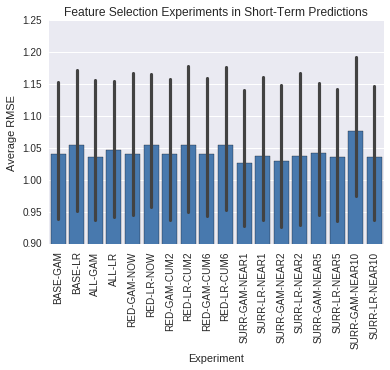

In [140]:
ax = sns.barplot(data=short_results, palette=sns.xkcd_palette(["windows blue"]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Average RMSE')
ax.set_xlabel('Experiment')
ax.set_ylim((0.9, 1.25))
ax.set_title('Feature Selection Experiments in Short-Term Predictions')
plt.savefig('reports/images/features-short-results.eps', format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

In [154]:
temp = short_results.describe().loc[['mean', 'std']].unstack().groupby(level=0).aggregate(lambda x: tuple(x))
temp = temp.apply(lambda x: '%.3f (%.3f)' % (x[0], x[1])).rename('AVG_RMSE').to_frame().sort_values(by=['AVG_RMSE'])
temp

,AVG_RMSE
SURR-GAM-NEAR1,1.026 (0.560)
SURR-GAM-NEAR2,1.030 (0.560)
SURR-LR-NEAR10,1.035 (0.572)
ALL-GAM,1.036 (0.559)
SURR-LR-NEAR5,1.036 (0.571)
SURR-LR-NEAR2,1.037 (0.570)
SURR-LR-NEAR1,1.037 (0.572)
RED-GAM-CUM2,1.040 (0.566)
BASE-GAM,1.040 (0.567)
RED-GAM-CUM6,1.041 (0.566)


In [155]:
print temp.to_latex()

\begin{tabular}{ll}
\toprule
{} &       AVG\_RMSE \\
\midrule
SURR-GAM-NEAR1  &  1.026 (0.560) \\
SURR-GAM-NEAR2  &  1.030 (0.560) \\
SURR-LR-NEAR10  &  1.035 (0.572) \\
ALL-GAM         &  1.036 (0.559) \\
SURR-LR-NEAR5   &  1.036 (0.571) \\
SURR-LR-NEAR2   &  1.037 (0.570) \\
SURR-LR-NEAR1   &  1.037 (0.572) \\
RED-GAM-CUM2    &  1.040 (0.566) \\
BASE-GAM        &  1.040 (0.567) \\
RED-GAM-CUM6    &  1.041 (0.566) \\
RED-GAM-NOW     &  1.041 (0.567) \\
SURR-GAM-NEAR5  &  1.042 (0.563) \\
ALL-LR          &  1.047 (0.571) \\
RED-LR-CUM6     &  1.055 (0.579) \\
RED-LR-CUM2     &  1.055 (0.579) \\
RED-LR-NOW      &  1.055 (0.580) \\
BASE-LR         &  1.055 (0.580) \\
SURR-GAM-NEAR10 &  1.076 (0.564) \\
\bottomrule
\end{tabular}



## Mid

In [17]:
with open("data/parsed/baseline_mid.p", "rb") as f:
    baseline_mid = pickle.load(f)
    
with open("data/parsed/all_mid.p", "rb") as f:
    all_mid = pickle.load(f)
    
with open("data/parsed/redistribution_mid.p", "rb") as f:
    redistribution_experiments_mid = pickle.load(f)    

with open("data/parsed/surrounding_mid.p", "rb") as f:
    surrounding_stations_experiments_mid = pickle.load(f)

In [18]:
baseline_mid_df = convert_results_to_df(baseline_mid, 'MID-BASE')
baseline_mid_df[['MID-BASE-EXP0-GAM-ERR', 'MID-BASE-EXP0-LR-ERR']].mean()

MID-BASE-EXP0-GAM-ERR    2.466258
MID-BASE-EXP0-LR-ERR     2.669326
dtype: float64

In [19]:
all_mid_df = convert_results_to_df(all_mid, 'MID-ALL')
all_mid_df[['MID-ALL-EXP0-GAM-ERR', 'MID-ALL-EXP0-LR-ERR']].mean()

MID-ALL-EXP0-GAM-ERR    2.490106
MID-ALL-EXP0-LR-ERR     2.625876
dtype: float64

In [20]:
redistribution_mid_df = convert_results_to_df(redistribution_experiments_mid, 'MID-RED')
redistribution_mid_df[['MID-RED-EXP0-GAM-ERR', 'MID-RED-EXP0-LR-ERR',
                         'MID-RED-EXP1-GAM-ERR', 'MID-RED-EXP1-LR-ERR',
                         'MID-RED-EXP2-GAM-ERR', 'MID-RED-EXP2-LR-ERR']].mean()

MID-RED-EXP0-GAM-ERR    2.466491
MID-RED-EXP0-LR-ERR     2.667585
MID-RED-EXP1-GAM-ERR    2.466651
MID-RED-EXP1-LR-ERR     2.664827
MID-RED-EXP2-GAM-ERR    2.467304
MID-RED-EXP2-LR-ERR     2.666673
dtype: float64

In [21]:
surrounding_mid_df = convert_results_to_df(surrounding_stations_experiments_mid, 'MID-SURR')
surrounding_mid_df[['MID-SURR-EXP0-GAM-ERR', 'MID-SURR-EXP0-LR-ERR',
                      'MID-SURR-EXP1-GAM-ERR', 'MID-SURR-EXP1-LR-ERR',
                      'MID-SURR-EXP2-GAM-ERR', 'MID-SURR-EXP2-LR-ERR',
                      'MID-SURR-EXP3-GAM-ERR', 'MID-SURR-EXP3-LR-ERR']].mean()

MID-SURR-EXP0-GAM-ERR    2.454693
MID-SURR-EXP0-LR-ERR     2.594404
MID-SURR-EXP1-GAM-ERR    2.481829
MID-SURR-EXP1-LR-ERR     2.585305
MID-SURR-EXP2-GAM-ERR    2.611988
MID-SURR-EXP2-LR-ERR     2.556595
MID-SURR-EXP3-GAM-ERR    2.875410
MID-SURR-EXP3-LR-ERR     2.550863
dtype: float64

In [22]:
mid_results = baseline_mid_df.merge(all_mid_df, how='inner', right_index=True, left_index=True)
mid_results = mid_results.merge(redistribution_mid_df, how='inner', right_index=True, left_index=True)
mid_results = mid_results.merge(surrounding_mid_df, how='inner', right_index=True, left_index=True)
mid_results.columns = ['BASE-GAM', 'BASE-LR', 
                         'ALL-GAM', 'ALL-LR',
                         'RED-GAM-NOW', 'RED-LR-NOW', 
                         'RED-GAM-CUM2', 'RED-LR-CUM2', 
                         'RED-GAM-CUM6', 'RED-LR-CUM6',
                         'SURR-GAM-NEAR1', 'SURR-LR-NEAR1',
                         'SURR-GAM-NEAR2', 'SURR-LR-NEAR2',
                         'SURR-GAM-NEAR5', 'SURR-LR-NEAR5',
                         'SURR-GAM-NEAR10', 'SURR-LR-NEAR10']

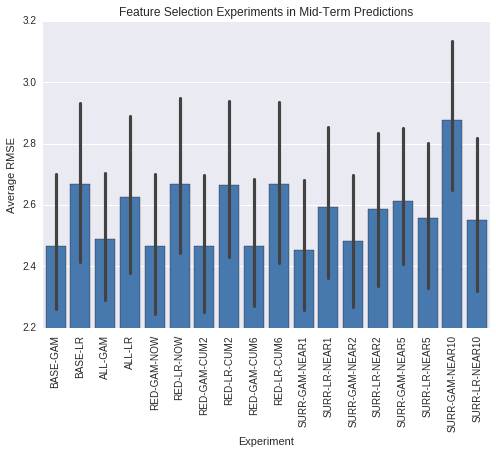

In [23]:
ax = sns.barplot(data=mid_results, palette=sns.xkcd_palette(["windows blue"]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Average RMSE')
ax.set_xlabel('Experiment')
ax.set_ylim((2.2, 3.2))
ax.set_title('Feature Selection Experiments in Mid-Term Predictions')
plt.savefig('reports/images/features-mid-results.eps', format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

In [24]:
mid_results.mean()['ALL-LR'] - mid_results.mean()['BASE-GAM'] 

0.15961820863206366

In [25]:
mid_results.describe()

,BASE-GAM,BASE-LR,ALL-GAM,ALL-LR,RED-GAM-NOW,RED-LR-NOW,RED-GAM-CUM2,RED-LR-CUM2,RED-GAM-CUM6,RED-LR-CUM6,SURR-GAM-NEAR1,SURR-LR-NEAR1,SURR-GAM-NEAR2,SURR-LR-NEAR2,SURR-GAM-NEAR5,SURR-LR-NEAR5,SURR-GAM-NEAR10,SURR-LR-NEAR10
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.466258,2.669326,2.490106,2.625876,2.466491,2.667585,2.466651,2.664827,2.467304,2.666673,2.454693,2.594404,2.481829,2.585305,2.611988,2.556595,2.875410,2.550863
std,1.121694,1.318272,1.106433,1.269462,1.121560,1.315926,1.121920,1.313380,1.122106,1.316839,1.105262,1.272793,1.102039,1.256843,1.125005,1.234688,1.186737,1.214002
min,0.950668,0.959756,0.985007,0.908786,0.950929,0.960014,0.954573,0.962336,0.954314,0.960789,0.969579,0.909877,0.966451,0.959497,0.989616,0.939383,1.104087,1.007413
25%,1.779269,1.869788,1.811169,1.876049,1.779826,1.873355,1.780175,1.871676,1.778851,1.872237,1.788585,1.867686,1.841094,1.842544,1.897534,1.870241,2.056974,1.835611
50%,2.208378,2.330228,2.220356,2.320807,2.209162,2.330276,2.208491,2.327193,2.205970,2.331304,2.221527,2.317920,2.268333,2.319896,2.348484,2.294749,2.671544,2.285478
75%,2.709800,2.936727,2.751171,2.889018,2.711841,2.935876,2.714932,2.942281,2.714451,2.945483,2.698256,2.778909,2.741765,2.793840,2.911632,2.828984,3.387638,2.772217
max,8.003193,8.604920,7.821261,8.496177,8.003409,8.602095,8.006818,8.620211,8.018611,8.637370,7.824843,8.497111,7.794006,8.491768,7.984857,8.533460,8.375785,8.473260


In [156]:
temp = mid_results.describe().loc[['mean', 'std']].unstack().groupby(level=0).aggregate(lambda x: tuple(x))
temp = temp.apply(lambda x: '%.3f (%.3f)' % (x[0], x[1])).rename('AVG_RMSE').to_frame()
temp.sort_values(by=['AVG_RMSE'])

,AVG_RMSE
SURR-GAM-NEAR1,2.455 (1.105)
BASE-GAM,2.466 (1.122)
RED-GAM-NOW,2.466 (1.122)
RED-GAM-CUM2,2.467 (1.122)
RED-GAM-CUM6,2.467 (1.122)
SURR-GAM-NEAR2,2.482 (1.102)
ALL-GAM,2.490 (1.106)
SURR-LR-NEAR10,2.551 (1.214)
SURR-LR-NEAR5,2.557 (1.235)
SURR-LR-NEAR2,2.585 (1.257)


In [157]:
print temp.to_latex()

\begin{tabular}{ll}
\toprule
{} &       AVG\_RMSE \\
\midrule
BASE-GAM        &  2.466 (1.122) \\
BASE-LR         &  2.669 (1.318) \\
ALL-GAM         &  2.490 (1.106) \\
ALL-LR          &  2.626 (1.269) \\
RED-GAM-NOW     &  2.466 (1.122) \\
RED-LR-NOW      &  2.668 (1.316) \\
RED-GAM-CUM2    &  2.467 (1.122) \\
RED-LR-CUM2     &  2.665 (1.313) \\
RED-GAM-CUM6    &  2.467 (1.122) \\
RED-LR-CUM6     &  2.667 (1.317) \\
SURR-GAM-NEAR1  &  2.455 (1.105) \\
SURR-LR-NEAR1   &  2.594 (1.273) \\
SURR-GAM-NEAR2  &  2.482 (1.102) \\
SURR-LR-NEAR2   &  2.585 (1.257) \\
SURR-GAM-NEAR5  &  2.612 (1.125) \\
SURR-LR-NEAR5   &  2.557 (1.235) \\
SURR-GAM-NEAR10 &  2.875 (1.187) \\
SURR-LR-NEAR10  &  2.551 (1.214) \\
\bottomrule
\end{tabular}



## Long

In [235]:
with open("data/parsed/baseline_long.p", "rb") as f:
    baseline_long = pickle.load(f)
    
with open("data/parsed/redistribution_long.p", "rb") as f:
    redistribution_experiments_long = pickle.load(f)    

with open("data/parsed/histavg_long.p", "rb") as f:
    histavg_long = pickle.load(f)
    
with open("data/parsed/all_long.p", "rb") as f:
    all_long = pickle.load(f)

In [236]:
baseline_long_df = convert_results_to_df(baseline_long, 'LONG-BASE')
baseline_long_df[['LONG-BASE-EXP0-GAM-ERR', 'LONG-BASE-EXP0-LR-ERR']].mean()

LONG-BASE-EXP0-GAM-ERR    5.905214
LONG-BASE-EXP0-LR-ERR     7.005691
dtype: float64

In [237]:
all_long_df = convert_results_to_df(all_long, 'LONG-ALL')
all_long_df[['LONG-ALL-EXP0-GAM-ERR', 'LONG-ALL-EXP0-LR-ERR']].mean()

LONG-ALL-EXP0-GAM-ERR    5.842051
LONG-ALL-EXP0-LR-ERR     5.754823
dtype: float64

In [238]:
redistribution_long_df = convert_results_to_df(redistribution_experiments_long, 'LONG-RED')
redistribution_long_df[['LONG-RED-EXP0-GAM-ERR', 'LONG-RED-EXP0-LR-ERR',
                         'LONG-RED-EXP1-GAM-ERR', 'LONG-RED-EXP1-LR-ERR',
                         'LONG-RED-EXP2-GAM-ERR', 'LONG-RED-EXP2-LR-ERR']].mean()

LONG-RED-EXP0-GAM-ERR    5.904407
LONG-RED-EXP0-LR-ERR     7.003992
LONG-RED-EXP1-GAM-ERR    5.902777
LONG-RED-EXP1-LR-ERR     7.001721
LONG-RED-EXP2-GAM-ERR    5.899102
LONG-RED-EXP2-LR-ERR     6.998777
dtype: float64

In [239]:
histavg_long_df = convert_results_to_df(histavg_long, 'LONG-AVG')
histavg_long_df[['LONG-AVG-EXP0-GAM-ERR', 'LONG-AVG-EXP0-LR-ERR']].mean()

LONG-AVG-EXP0-GAM-ERR    5.848333
LONG-AVG-EXP0-LR-ERR     5.758766
dtype: float64

In [240]:
long_results = baseline_long_df.merge(all_long_df, how='inner', right_index=True, left_index=True)
long_results = long_results.merge(redistribution_long_df, how='inner', right_index=True, left_index=True)
long_results = long_results.merge(histavg_long_df, how='inner', right_index=True, left_index=True)
long_results.columns = ['BASE-GAM', 'BASE-LR',                     
                         'ALL-GAM', 'ALL-LR',
                         'RED-GAM-NOW', 'RED-LR-NOW', 
                         'RED-GAM-CUM2', 'RED-LR-CUM2', 
                         'RED-GAM-CUM6', 'RED-LR-CUM6',
                         'HAVG-GAM', 'HAVG-LR']

In [245]:
long_results.describe()

,BASE-GAM,BASE-LR,ALL-GAM,ALL-LR,RED-GAM-NOW,RED-LR-NOW,RED-GAM-CUM2,RED-LR-CUM2,RED-GAM-CUM6,RED-LR-CUM6,HAVG-GAM,HAVG-LR
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,5.905214,7.005691,5.842051,5.754823,5.904407,7.003992,5.902777,7.001721,5.899102,6.998777,5.848333,5.758766
std,2.422349,2.904571,2.425327,2.428572,2.423109,2.904645,2.424375,2.905189,2.426362,2.908159,2.419924,2.424743
min,2.093546,2.610552,1.926347,1.893362,2.087139,2.610552,2.079282,2.610552,2.069837,2.610552,1.991550,1.910056
25%,4.328475,5.140352,4.266490,4.212153,4.328209,5.138435,4.328103,5.133909,4.326715,5.127173,4.271408,4.208961
50%,5.369488,6.360218,5.345587,5.364251,5.370762,6.358756,5.373306,6.356064,5.390913,6.354324,5.325396,5.343847
75%,7.279299,7.913298,7.202381,6.994752,7.279880,7.910924,7.262918,7.902234,7.233628,7.885705,7.188319,6.987897
max,15.183958,18.722175,15.052438,15.164573,15.185738,18.735775,15.191747,18.754246,15.193853,18.794194,15.029914,15.122434


In [242]:
long_results.mean()['BASE-LR'] - long_results.mean()['BASE-GAM'] 

1.1004766650572808

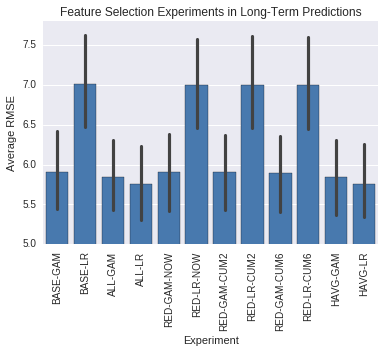

In [244]:
ax = sns.barplot(data=long_results, palette=sns.xkcd_palette(["windows blue"]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Average RMSE')
ax.set_xlabel('Experiment')
ax.set_ylim((5.0, 7.8))
ax.set_title('Feature Selection Experiments in Long-Term Predictions')
plt.savefig('reports/images/features-long-results.eps', format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

In [246]:
temp = long_results.describe().loc[['mean', 'std']].unstack().groupby(level=0).aggregate(lambda x: tuple(x))
temp = temp.apply(lambda x: '%.3f (%.3f)' % (x[0], x[1])).rename('AVG_RMSE').to_frame()
temp.sort_values(by=['AVG_RMSE'])

,AVG_RMSE
ALL-LR,5.755 (2.429)
HAVG-LR,5.759 (2.425)
ALL-GAM,5.842 (2.425)
HAVG-GAM,5.848 (2.420)
RED-GAM-CUM6,5.899 (2.426)
RED-GAM-CUM2,5.903 (2.424)
RED-GAM-NOW,5.904 (2.423)
BASE-GAM,5.905 (2.422)
RED-LR-CUM6,6.999 (2.908)
RED-LR-CUM2,7.002 (2.905)


In [247]:
print temp.to_latex()

\begin{tabular}{ll}
\toprule
{} &       AVG\_RMSE \\
\midrule
BASE-GAM     &  5.905 (2.422) \\
BASE-LR      &  7.006 (2.905) \\
ALL-GAM      &  5.842 (2.425) \\
ALL-LR       &  5.755 (2.429) \\
RED-GAM-NOW  &  5.904 (2.423) \\
RED-LR-NOW   &  7.004 (2.905) \\
RED-GAM-CUM2 &  5.903 (2.424) \\
RED-LR-CUM2  &  7.002 (2.905) \\
RED-GAM-CUM6 &  5.899 (2.426) \\
RED-LR-CUM6  &  6.999 (2.908) \\
HAVG-GAM     &  5.848 (2.420) \\
HAVG-LR      &  5.759 (2.425) \\
\bottomrule
\end{tabular}



## Proof

In [280]:
mid_results['ALL-GAM'].sort_values()[49:50]

Id
BikePoints_240    5.321182
Name: ALL-GAM, dtype: float64

In [281]:
training, validation, test = split_datasets(readings_long, 'BikePoints_240')

In [282]:
%load_ext rpy2.ipython

robjects.globalenv['data'] = training

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [284]:
%%R

library(mgcv)

gamModel <- gam(NbBikes ~ s(TempTMinus12, HumidityTMinus12, bs='tp') + s(TimeOfDay, by=Weekday, bs='tp') 
                + s(TimeOfDay, by=Weekend, bs='tp') + s(TimeOfDay, by=Holiday, bs='tp') + s(NbBikesTMinus12, bs='tp') 
                + s(NbBikesTMinus18, bs='tp'), data=data)

summary(gamModel)


Family: gaussian 
Link function: identity 

Formula:
NbBikes ~ s(TimeOfDay, by = Weekday, bs = "tp") + s(TimeOfDay, 
    by = Weekend, bs = "tp") + s(TimeOfDay, by = Holiday, bs = "tp") + 
    s(HistAvg, bs = "tp", k = 5) + CollNbBikesCum6 + DistNbBikesCum6

Parametric coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      5.14084    0.53005   9.699   <2e-16 ***
CollNbBikesCum6 -0.09851    0.06566  -1.500    0.134    
DistNbBikesCum6  0.13594    0.07686   1.769    0.077 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                       edf Ref.df      F p-value    
s(TimeOfDay):Weekday 8.422  9.264  6.100 5.7e-09 ***
s(TimeOfDay):Weekend 5.681  6.780  3.283 0.00208 ** 
s(TimeOfDay):Holiday 2.000  2.000  3.647 0.02612 *  
s(HistAvg)           1.000  1.000 83.421 < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Rank: 36/37
R-sq.(adj) =  0.122   Deviance e